# Monte Carlo approach to estimating confidence intervals

## Introduction
The purpose of this method is to estimate the confidence limits on the estimated model parameters.  This is achieved firstly by estimating the model parameters by optimising the model using standard non-linear solution methods (chi square regression in this case) for a single measurement of $R_{rs}$.  A set of 'hypothetical' data sets are generated by randomly peturbing the inputs and forward modelling the results.  If the input values are perturbed within the experimental uncertainty of those values, this process generates a set of synthetic realisations that will be used to estimate the distribution of input parameters.

There are a number of challenges to address.  Firstly, an apriori of the experimental uncerainty of the input parameters is expected.  This is precisely the problem we are trying to model.  It is often more easy to meaure the uncertainty of the output measurement through repeat measurements, instrument characterisation and/or sensitivity analysis.

Here we present an heuristic approach to refining estimates of the confidence intervales of the input parameters.  It is assumed that the ouput parameter ($R_{rs}$ in this specific case) uncertainty has been characterised.  Firstly, a set of synthetic realisations for a reasonable set of input variances are generated.  The synthetic set is then filtered so that only output values that fall within the output uncertainty are optimised and estimates of the input values are found for each realisation.

The process of generating the synthetic outputs is extremely slow using modelling packages such has Hydrolight and Planarrad and would be impractical to do this for every measurement.  This approach to estimating confidence intervals presented here is therefore extended so that a method of generating realsisations without the need for complex modelling packages.

A naive approach to generating synthetic reaslisations would be to generate random noise within the uncertainty range of the output parameter and multipy the noise with the measurement, repeating for as many iterations required to generate and statistically valid data set.  The problem with this approach is that random perterbations in 'nature' do not happen completely randomly.  Naturally occruing variations in CDOM for example will affect one part of the spectrum more than the other.  Furthermore, it is logical to assume that wavelengths that are close together will vary with much higher correlation that wavelengths that are far appart.  Or to be more accurate, certain wavelenths will be highly correlated and others will not.  In the case of phytoplankton, there are pigments such as chlorophyll-a that absorb more at ~440 nm and ~665 nm.  Therefore, naturally occuring vaiances in chlorophyll-a should affect variances in 440 nm and 665 nm. It may be found therefore that 440 nm and 665 nm are highly correlated.  

It is this correlation that we wish to be faithful to when we randomly peturb our values.  This is done by finding the power spectrum (also known as the Power Spectrum Density (PSD) function) of a synthetic data set and using the PSD to generate the random perturbations or 'noise'.  The PSD is a measure of the distribution of the variance over the comulative signals.  In fact, the autocovariance can be found by calculating the inverse Fourier transfrom of the PSD.  The autocovariance will describe, in this case, how the components in the Fourier domain vary with each other including the correlation length.   In this case the comulative signals are synthetic measurements generated using physics based modelling packages Hydrolight or Planarrad.

Once the PSD function has been modelled, new artifical realisations can be generated very quickly whithout the need for computationaly expensive Planarrad runs.  If the correct inputs are carefully chosen to model the natural variability expected in the signal.  The correlated noise model can be used to accurately generate synthetic realisation of $R_{rs}$ which can be used to estimate the variance of the input parameters and lastly infer confidence intervals and uncertainty on the original estimate from measurement.

Finaly, the natural variance on the input parameters were guessed.  It maybe the case that the variance was over estimated.  Therefore, in this method, the realisations that fell outside the uncertainty boundary of the measured $R_{rs}$ were filtered out.  Only the spectra that fell inside the boundary were use to estimate the input parameters.  An iterative approach could be used where only the spectra that fell withing the uncertainty boundary are used to re-calculate the power spectrum and the process repeated.

The most expesive part of the method outlined here is using Planarrad or Hydrolight to generate the many spectra required to cover all combinations of input parameters.  Therefore some sensible limitations need to be applied before this method could be used in a realistic scenario.  

Assumptions:

* The output reflectance spectra uncertainty is well characterised.
* The IOPs in the study area do not vary wildly in spectral shape.  
* IOPs can be modelled accurately using bio-optical models or are known from laboratory measurements.
* A good estimate of the naturally occuring variance in total IOP concentration is known. 

Summary of method

* Choose a phytoplankton spectra that best represents the absorption spectral shape.  This may be from laboratory measurements.
* Generate a database of reflectance spectra for all combinations of IOP input parameters using planarrad.  Vary the input parameters by slightly greater than they would be expected to vary in the study area.  This database will be filtred later to a subset of data used for modelling the uncertainty.  Generating a database that is greater in size than is required for each measurement will mean that a lookup table can be used rather than having to run Planarrad more than once.
* Detrend the enseble average of all the reflenctance spectra  
$\Delta_{Rrs}$.
* Calculate the standard deviation  
$\sigma_{\Delta_{Rrs}(\lambda)}$
* Calculate the normalised difference of the standard deviation   
$\bar{\Delta}_{Rrs}(\lambda) = \frac{\Delta_{Rrs}(\lambda)}{\sigma_{\Delta_{Rrs}(\lambda)}}$
* Calculate the power spectrum   
$Y = \mathcal{F}\{\bar{\Delta}_{rs}(\lambda)\}$  
$S_{\lambda \lambda} = \left<YY^*\right>$

The method is described in the following section.

### Generate a set of $R_{rs}$ using Planarrad or Hydrolight

A range of reflectance spectra using different input values of; phytoplankton, CDOM, particulate scattering and wind speed values were generated and all combinations of them were batch run in Planarrad with a fixed Sun geometry of 0, 0 deg azimuth, zenith respectively.  

Populating the interactive namespace from numpy and matplotlib
'08/16/2016 07:50:52 PM' :: libbootstrappy :: INFO :: Reading :: /home/marrabld/Projects/oo2016/notebooks/inputs/swan_data/0_ARM_14Nov11_1212.csv


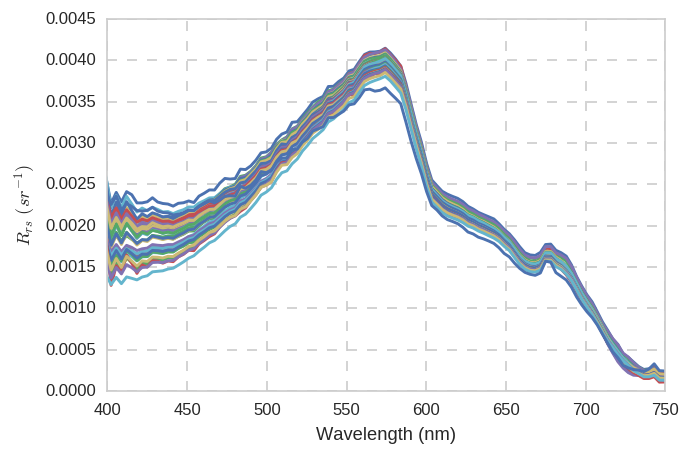

(110,)
(110,)
(43, 110)


In [128]:
%pylab inline
#matplotlib.rcParams['savefig.dpi'] = 130

import sys
import seaborn as sns
import numpy as np
import os

matplotlib.rcParams['savefig.dpi'] = 120
import seaborn as sns
sns.set_style('whitegrid',{'grid.linestyle': u'--'})


sys.path.append('..')

import libbootstrap.spectralmodel as spectralmodel

#test_data_file = '/home/marrabld/Dropbox/2_PhD/bootstrap/bootstrappy/inputs/test_data/Rrs.csv'
_data_file = '0_BLA_14Nov11_1146.csv'
_data_file = '0_HEA_14Nov11_1232.csv'
_data_file = '0_ARM_14Nov11_1212.csv'
#test_data_file = '/home/marrabld/Dropbox/2_PhD/bootstrap/bootstrappy/inputs/test_data/high_batch_report.csv'

data_dir = '/home/marrabld/Projects/oo2016/notebooks/inputs/swan_data'
data_file = os.path.join(data_dir, _data_file)
out_csv = 'out.csv'

sm = spectralmodel.BuildSpectralModel(data_file)

#sns.axes_style("darkgrid")
    
for row in sm.Rrs:
    pylab.plot(sm.wave, row)
    
pylab.xlabel('Wavelength (nm)')
pylab.ylabel('$R_{rs}$ $(sr^{-1})$')
#pylab.title('Planarrad generated reflectance')
pylab.xlim([400, 750])
pylab.show()

print(row.shape)
print(sm.wave.shape)

print(sm.Rrs.shape)

### Detrend $R_{rs}(\lambda)$ by subtracting the ensemble average

$\Delta_{rs}(\lambda) = R_{rs}(\lambda) - \left<R_{rs}(\lambda)\right>$

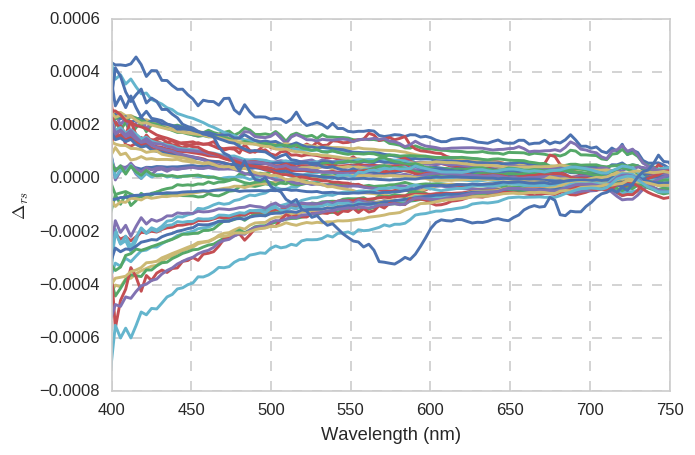

In [109]:
sm._detrend()

for row in sm.delta_Rrs:
    pylab.plot(sm.wave, row)

pylab.xlabel('Wavelength (nm)')
pylab.ylabel('$\Delta_{rs}$')
#pylab.title('Detrended reflectance')
pylab.xlim([400, 750])
pylab.show()

### Calculate standard devation of $\Delta_{rs}(\lambda)$  .

$\sigma_{\Delta_{rs}(\lambda)}$

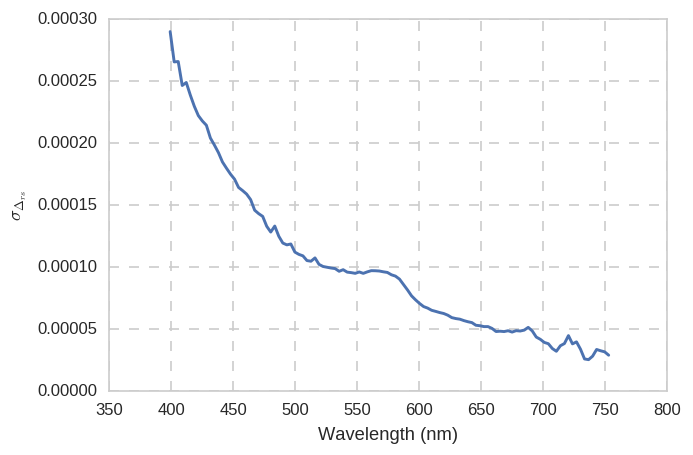

In [110]:
sm._calc_std_delta_Rrs()

pylab.plot(sm.wave, sm.std_delta_Rrs)

pylab.xlabel('Wavelength (nm)')
pylab.ylabel('$\sigma_{\Delta_{rs}}$')
#pylab.title('Standard deviation of detrended reflectance')

pylab.show()

### Calculate the normalised difference.  This step is to make sure the data is 'stationary'.

$\bar{\Delta}_{rs}(\lambda) = \frac{\Delta_{rs}(\lambda)}{\sigma_{\Delta_{rs}(\lambda)}}$
    

    

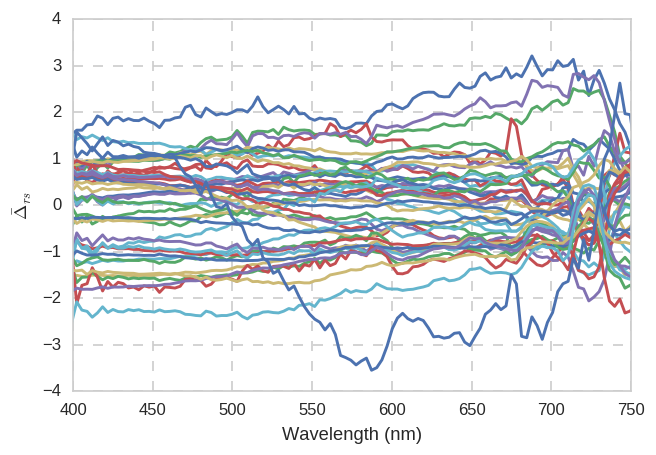

(110,)
(43, 110)


In [111]:
sm._calc_normalised_difference_Rrs()

for row in sm.delta_hat_Rrs:
    pylab.plot(sm.wave, row)
    
pylab.xlabel('Wavelength (nm)')
pylab.ylabel(r'$\bar{\Delta}_{rs}$')
#pylab.title('Normalised reflectance')

pylab.xlim([400, 750])
pylab.show()
print(sm.wave.shape)
print(sm.delta_hat_Rrs.shape)

### Check the distribution

Below is the disribution of reflectance values for each wavelength.  Blue -> Red top to bottom.

IndexError: index 17 is out of bounds for axis 0 with size 17

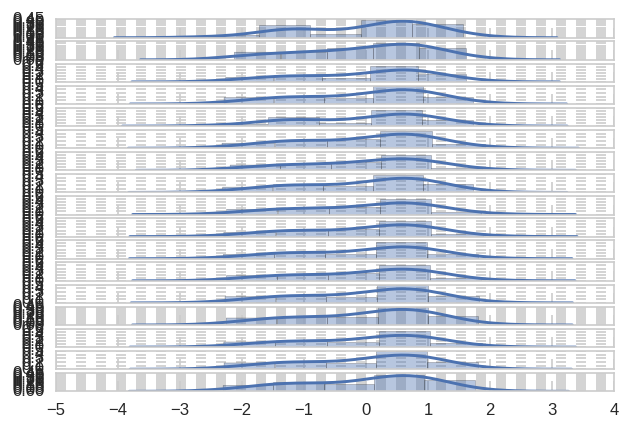

In [112]:
f, axarr = plt.subplots(17, sharex=True)

for i_iter in range(0,sm.delta_hat_Rrs.shape[1]):
    sns.distplot(sm.delta_hat_Rrs[:, i_iter], ax=axarr[i_iter])

### Calculate the power spectrum

The power spectrum is calculated by multiplying the Fourier transform of normalised diference ($\bar\Delta_{rs}$) with the complex conjugate of itself and averaging the results.

$Y = \mathcal{F}\{\bar{\Delta}_{rs}(\lambda)\}$

$S_{\lambda \lambda} = \left<YY^*\right>$

The resulting power spectrum is used in later steps to generate correlated noise model in which realisation of $R_{rs}$ will be generated.

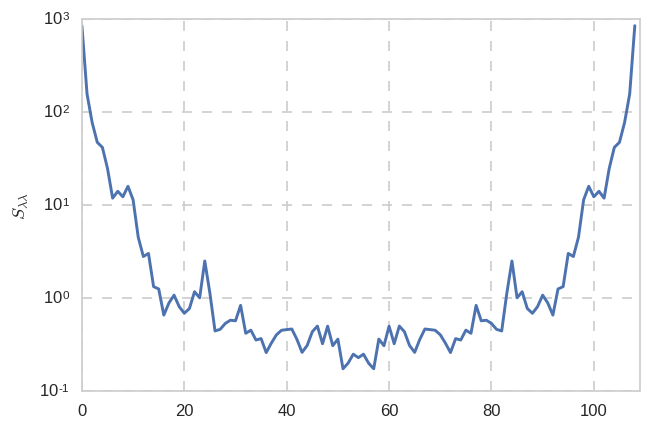

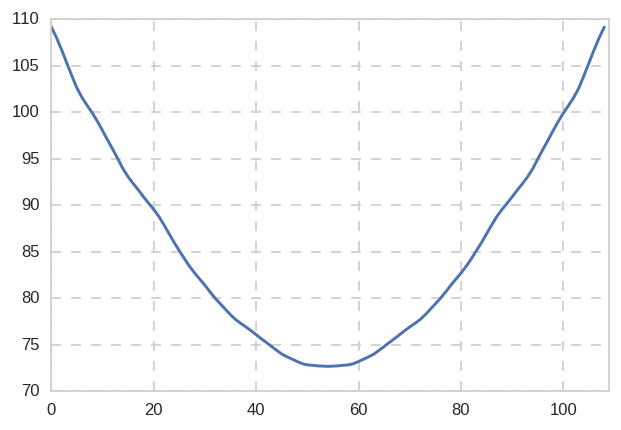

(110,)
(110,)


In [113]:
sm._calc_power_spectrum()

pylab.semilogy(np.real(sm.Syy[1:]))

pylab.ylabel('$S_{\lambda \lambda}$')
#pylab.xlim((0, 15))
#pylab.title('Power spectrum')
pylab.xlim([0, sm.Syy.shape[0]-1])
pylab.show()

import scipy
cf = scipy.ifft(sm.Syy)
pylab.plot(cf[1:])
#pylab.xlim((0, 15))
#pylab.title('Correlation function')
pylab.xlim([0, sm.Syy.shape[0]-1])
pylab.show()

print(cf.shape)
print(sm.Syy.shape)

# Generating synthetic realisations

For each wavelength we wish to randomly generate a value within the defined variance of that wavelength.  To do that we first generate random numbers $n$ between $-0.5 \rightarrow 0.5$.  As first approximation, a guassian distribution can be used but the distribution that is used should comform to the distribtuion found in step 4 previous.  These random values will later be scaled by the power spectrum.

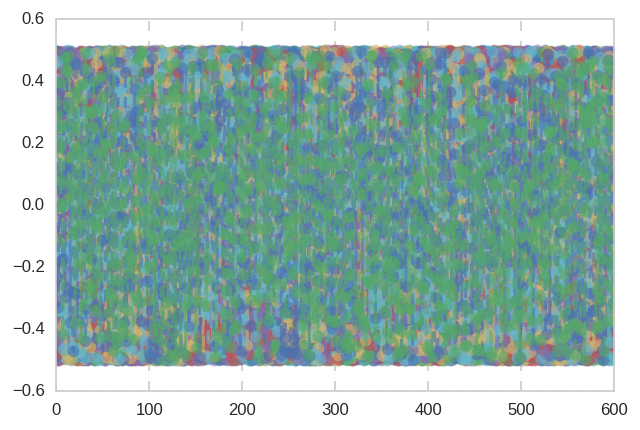

In [114]:
import libbootstrap.spectra_generator as spectra_generator

num_realizations = 600

sg = spectra_generator.GenerateRealisation(sm, num_realizations)
rn = sg._gen_random_numbers(num_realizations)

pylab.plot(rn, '--o', alpha = 0.6)
pylab.show()


### Calculate the FFT of n

Before the radom values can be scaled by the powerspectrum they must first be transformed in to the Fourier domain by taking the descrete Fourier transform of the randomly generated numbers.

N = $\mathcal{F}\{n\}$

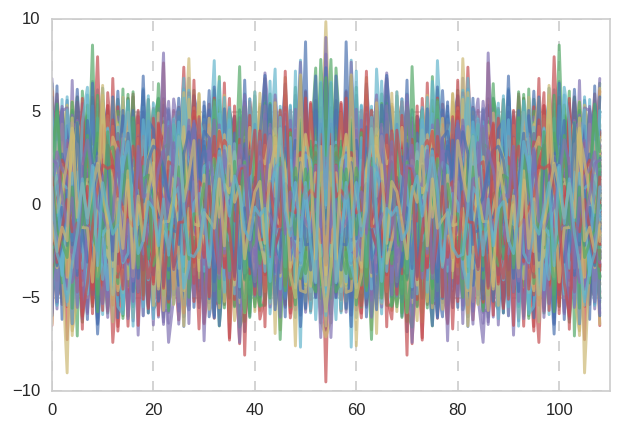

In [124]:
N = sg._calc_fft_random_numbers()

for row in N:
    pylab.plot(row[1:], alpha = 0.7)
#pylab.title('Fourier transform of n : $\mathcal{F}\{n\}$')
pylab.xlim((0, 110))
pylab.show()

### Multiply the FFT of n by the squareroot of the powerspectrum

Now that the randome numbers are in the Fourier domain they are multiplied by the square of the power spectrum in order to scale them.  The result is correlated noise in the Fourier domain

$Y = N \times \sqrt{S_{\lambda\lambda}}$

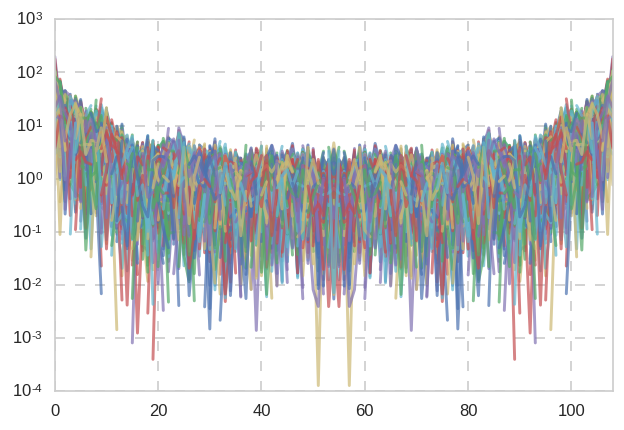

In [125]:
Y = sg._calc_rand_powerspectrum()

for row in Y:
    pylab.semilogy(row[1:], alpha = 0.7)
#pylab.title('Correlated Noise (Y)')
pylab.xlim((0, 108))
pylab.show()

The resulting correlated noise (Y) is transformed back to the real domain ($y(\lambda)$) by calculating the inverse Fourier transform

$y(\lambda) = \mathcal{F}^{-1}\{Y\}$

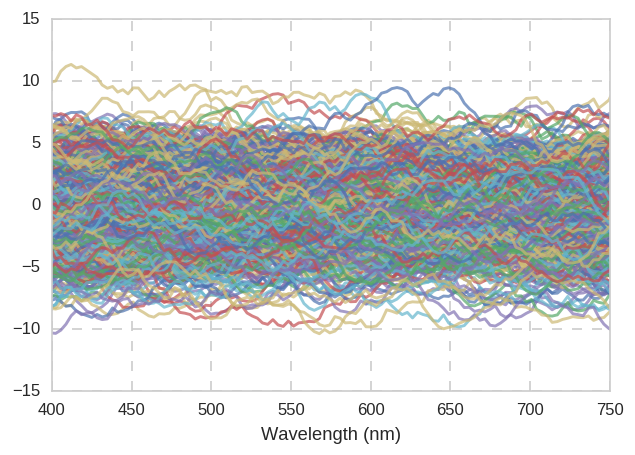

In [126]:
y = sg._calc_inv_rand_powerspectrum() # lowercase y

for row in y:
    pylab.plot(sm.wave, row, alpha = 0.7)
    
pylab.xlabel('Wavelength (nm)')
#pylab.title('Correlated Noise $y(\lambda)$')
pylab.xlim((400, 750))
pylab.show()

### Normalise the difference

We must make sure that all the wavelengths of the correlated noise in the real domain have a standard deviation of 1 so that they can be multiplied by the standard deviation of the original $R_{rs}$.  This is done by dividing $y(\lambda)$ by the standard deviation of itself.

$\bar{y}(\lambda) = \frac{y(\lambda)}{\sigma_y}$

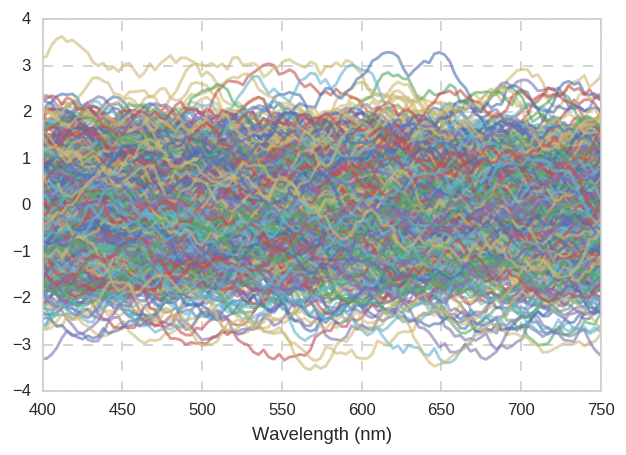

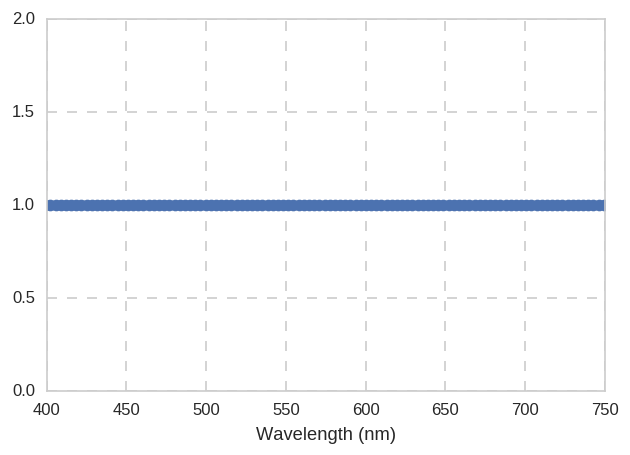

In [127]:
y_hat = sg._calc_normalised_difference_inv_rand_powerspectrum()

for row in y_hat:
    pylab.plot(sm.wave, row, alpha = 0.6)
    
pylab.xlabel('Wavelength (nm)')
#pylab.title(r'Normalised-Correlated Noise ($\bar{y}(\lambda)$)')
pylab.xlim((400, 750))
pylab.show()

std_y_hat = scipy.std(y_hat, axis=0)
pylab.plot(sm.wave, std_y_hat, '--o')
pylab.axis([400, 750, 0, 2])
pylab.xlabel('Wavelength (nm)')
#pylab.title('Std of normalised-correlated noise (should be 1.0 for all wavelengths)')

pylab.show()

The standard deviation of the modelled $R_{rs}$ is multiplied by the normalised-correlated noise

$z(\lambda) = \bar{y}(\lambda) \sigma_{\Delta_{rs}(\lambda)}$

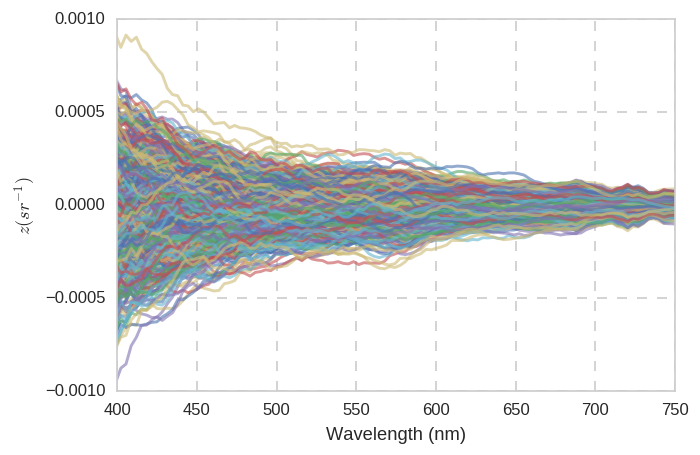

In [119]:
z = sg._calc_z()

for row in z:
    pylab.plot(sm.wave, row, alpha = 0.6)
    
pylab.xlabel('Wavelength (nm)')
pylab.ylabel(r'$z (sr^{-1})$')
#pylab.title('Detrended realisations $z(\lambda)$')
pylab.xlim((400, 750))
pylab.show()


### Generate a realisation of $R_{rs}$ by adding back the mean value substracted in step 2 of defining the noise model

$\hat{R}_{rs}(\lambda) = \left<R_{rs}(\lambda)\right> + z(\lambda)$

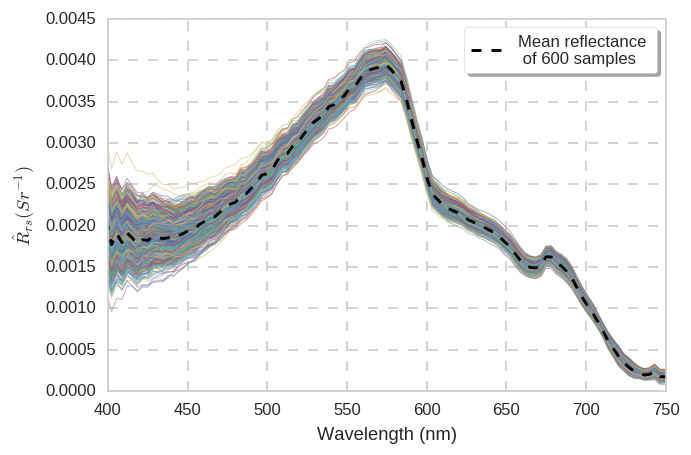

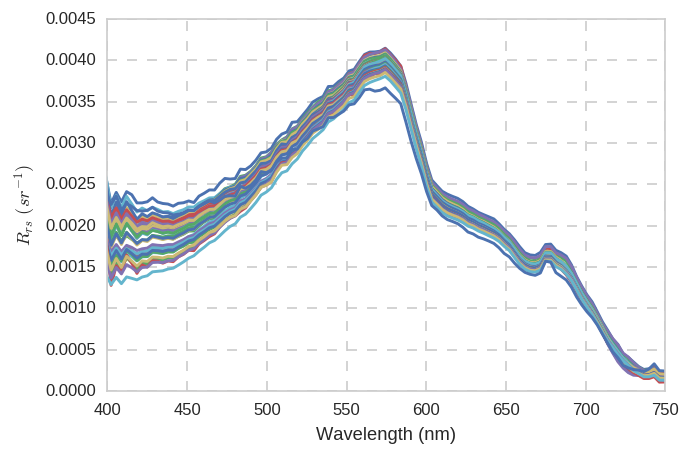

In [120]:
# pinch an Rrs from sm 
Rrs_1 = np.mean(sm.Rrs[10:,:], axis=0)
#Rrs_1 = Rrs[50, :] #sm.mean_Rrs  This isa spoof!

# Generate realisations from it.
Rrs = sg.gen_Rrs()

for row in Rrs:
    pylab.plot(sm.wave, row, alpha = 0.6, linewidth=0.550)
    
pylab.xlim((400, 750))
pylab.plot(sm.wave, Rrs_1, 'k--', label='Mean reflectance \n of 600 samples') #sm.mean_Rrs

#pylab.title(str(num_realizations) + ' Realisations generated from one reflectance, using our powerspectrum model')
pylab.xlabel('Wavelength (nm)')
pylab.ylabel(r'$\hat{R}_{rs} (Sr^{-1})$')
pylab.legend(frameon=True, fancybox=True, shadow=True)
pylab.xlim((400, 750))
pylab.show()

for row in sm.Rrs:
    pylab.plot(sm.wave, row)
    
pylab.xlabel('Wavelength (nm)')
pylab.ylabel('$R_{rs}$ $(sr^{-1})$')
#pylab.title('Planarrad generated reflectance')
pylab.xlim((400, 750))
pylab.show()


### Filter our reflectances

This is more variance in our reflectance than we expect to see from a single measurement.  This data is usefull as a senstivity analysis only.  Let us say that expect that the Reflectance will vary by say 1.5%.  So we identify reflectances in the ensemble that are withing those bounds and invert those using a deep water analytical model.

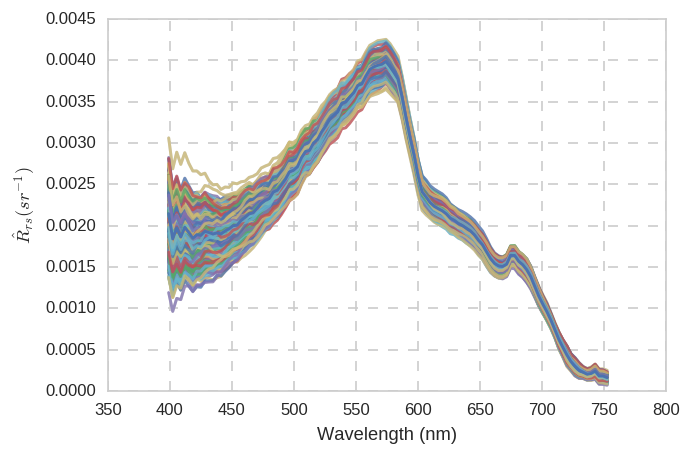

In [121]:
Rrs_1 = sm.mean_Rrs
range_val = 0.02


Rrs_norm = np.zeros(Rrs.shape[0])

for i_iter in range(0, Rrs.shape[0]):
    Rrs_norm[i_iter] = np.real(np.linalg.norm(Rrs[i_iter, :] - Rrs_1))
    
idx_sub_Rrs = Rrs_norm < range_val

#for i_iter in range(0, Rrs.shape[0])
sub_Rrs = Rrs[idx_sub_Rrs, :]

for row in Rrs:
    pylab.plot(sm.wave, row, color='0.85')
    
for row in sub_Rrs:
    pylab.plot(sm.wave, row, alpha = 0.75)
    
pylab.plot(sm.wave, Rrs_1)
    
#pylab.title('Filter our realizations so we only include the ones that vary slightly from our measured $R_{rs}$')
pylab.xlabel('Wavelength (nm)')
pylab.ylabel(r'$\hat{R}_{rs} (sr^{-1})$')
pylab.show()



Now we save these spectra to a tempory file and pass them to the deconvolution method.

In [122]:
#!mkdir tmp
!ls
import sys
sys.path.append("..")

import libbootstrap
import libbootstrap.deconv

rrs_file = './tmp/Rrs.csv'
np.savetxt(rrs_file, np.vstack((sm.wave, np.real(Rrs))), delimiter=',');

#wavelengths = scipy.asarray([470., 490., 510., 530., 550., 570., 590., 610., 630., 650., 670., 690., 710., 730.])
#dc = libbootstrap.deconv.McKeeModelCase2(sm.wave);
#dc = libbootstrap.deconv.QAA(sm.wave);
dc = libbootstrap.deconv.HopeDeep(sm.wave);
#dc = libbootstrap.deconv.BCDeep(sm.wave);


dc.read_rrs_from_file(rrs_file);
dc.read_all_iops_from_files();

data = dc.run(num_iters=1);
print(data);
check = dc.func(data[0]);
#import pylab

for row in sub_Rrs:
    pylab.plot(sm.wave, row, color= '0.75', alpha = 0.75);
    
pylab.plot(sm.wave, check, '*');
pylab.xlabel('Wavelength (nm)')
pylab.ylabel(r'$\hat{R}_{rs} (sr^{-1})$')
pylab.show();
    


bootstrap_test.ipynb	 high.csv     med.csv			Untitled.ipynb
forwardmodel_test.ipynb  __init__.py  powerspectrum_test.ipynb
fwd_model_test.py	 low.csv      tmp
'08/16/2016 06:52:57 PM' :: libbootstrappy :: INFO :: Reading subsurface reflectance from file
'08/16/2016 06:52:57 PM' :: libbootstrappy :: INFO :: Reading :: ./tmp/Rrs.csv :: and interpolating to [[ 399.08673228  402.33110236  405.57547244  408.81984252  412.0642126
   415.30858268  418.55295276  421.79732283  425.04169291  428.28606299
   431.53043307  434.77480315  438.01917323  441.26354331  444.50791339
   447.75228347  450.99665354  454.24102362  457.4853937   460.72976378
   463.97413386  467.21850394  470.46287402  473.70724409  476.95161417
   480.19598425  483.44035433  486.68472441  489.92909449  493.17346457
   496.41783465  499.66220472  502.9065748   506.15094488  509.39531496
   512.63968504  515.88405512  519.1284252   522.37279528  525.61716535
   528.86153543  532.10590551  535.35027559  538.59464567  541.83901

ValueError: could not broadcast input array from shape (3) into shape (4)

### IOP Distibution

If we look at the disributions of our inverted parameters we can take a 95% confidence interval as our uncertainty.  Below is the distribution of aphi and CDOM over all of the bootstraps


In [ ]:
with sns.axes_style("white"):
    sns.jointplot(data[2][:,0],data[2][:,1], kind="hex");
    
sns.axlabel('$a\phi(440)$', '$a_g(400)$')
plt.hold(True)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

x = data[2][:,0]#[5,7,11,15,16,17,18]
y = data[2][:,1]#[25, 18, 17, 9, 8, 5, 8]

error_ellipse_plot(x, y)

z = numpy.vstack((x, y))
numpy.savetxt(out_csv, z, delimiter=",")


#with sns.axes_style("white"):
#    graph = sns.jointplot(data[2][:,0],data[2][:,1], kind='hex');
    
sns.axlabel('$a_\phi(440)(m^{-1})$', '$a_g(400)(m^{-1})$')

with sns.axes_style("white"):
    graph = sns.jointplot(x=data[2][:,0], y=data[2][:,1], s=5).set_axis_labels('$a_\phi(440)(m^{-1})$', '$a_g(400)(m^{-1})$')
    
ax = graph.fig.gca()
print(ax.get_xlim())
#ax.add_patch(ell)

#graph.x = data[2][:,0]
#graph.y = data[2][:,1]
#graph.plot_joint(plt.scatter, marker='x', c='b', s=50)
plt.xlim([0, 1.0])
plt.show()

In [ ]:
# plot
# ========================================   
graph = sns.jointplot(x=df1.x1, y=df1.y1, color='r')

graph.x = df2.x2
graph.y = df2.y2
graph.plot_joint(plt.scatter, marker='x', c='b', s=50)

In [ ]:
with sns.axes_style("white"):
    sns.jointplot(data[2][:,0],data[2][:,1], kind="kde").set_axis_labels('$a_\phi(440)$', '$a_g(400)$');
    

In [ ]:
textfile_list = ['low.csv', 'med.csv', 'high.csv']

low_aphi = numpy.loadtxt(textfile_list[0], delimiter=",")

# We sort the values so we can drop the ones close to 0 where the optimization diverged
# arr[arr[:, 1].argsort()]

idx_filt_low_aphi = numpy.argsort(low_aphi[0, :])


filt_low_aphi = low_aphi[:, idx_filt_low_aphi]

med_aphi = numpy.loadtxt(textfile_list[1], delimiter=",")
high_aphi = numpy.loadtxt(textfile_list[2], delimiter=",")

filt_depth = 590

clf()

x = filt_low_aphi[0, filt_depth:]
y = filt_low_aphi[1, filt_depth:]

plot(x, y, 'o')

error_ellipse_plot(x, y)
plt.xlim([0, 2])

with sns.axes_style("white"):
    graph = sns.jointplot(x=x, y=y, s=5).set_axis_labels('$a_\phi(440)(m^{-1})$', '$a_g(400)(m^{-1})$')
#plt.xlim([0, 2])
   
plt.hold(True)   

In [ ]:
med_aphi = numpy.loadtxt(textfile_list[1], delimiter=",")

# We sort the values so we can drop the ones close to 0 where the optimization diverged
# arr[arr[:, 1].argsort()]

idx_filt_med_aphi = numpy.argsort(med_aphi[0, :])


filt_med_aphi = med_aphi[:, idx_filt_med_aphi]

med_aphi = numpy.loadtxt(textfile_list[1], delimiter=",")

filt_depth = 200

clf()

x = filt_med_aphi[0, filt_depth:]
y = filt_med_aphi[1, filt_depth:]

#plot(x, y, 'o')

error_ellipse_plot(x, y)
plt.xlim([0, 2])
plt.ylim(0.013, 0.018)
with sns.axes_style("white"):
    graph = sns.jointplot(x=x, y=y, s=5).set_axis_labels('$a_\phi(440)(m^{-1})$', '$a_g(400)(m^{-1})$')
plt.ylim(0.013, 0.018)


In [ ]:
high_aphi = numpy.loadtxt(textfile_list[2], delimiter=",")

# We sort the values so we can drop the ones close to 0 where the optimization diverged
# arr[arr[:, 1].argsort()]

idx_filt_high_aphi = numpy.argsort(high_aphi[0, :])


filt_high_aphi = high_aphi[:, idx_filt_high_aphi]



filt_depth = 80

clf()

x = filt_high_aphi[0, filt_depth:]
y = filt_high_aphi[1, filt_depth:]

#plot(x, y, 'o')

error_ellipse_plot(x, y)
plt.xlim([0, 2])
plt.ylim(0.014, 0.016)

with sns.axes_style("white"):
    graph = sns.jointplot(x=x, y=y, s=5).set_axis_labels('$a_\phi(440)(m^{-1})$', '$a_g(400)(m^{-1})$')
plt.ylim(0.014, 0.016)
    
    

In [ ]:
filt_depth = 590

#clf()

x = filt_low_aphi[0, filt_depth:]
y = filt_low_aphi[1, filt_depth:]

#plot(x, y, 'o', label='Low', alpha=0.7)
error_ellipse_plot(x, y, plotcolour='r')

filt_depth = 400


x = filt_med_aphi[0, filt_depth:]
y = filt_med_aphi[1, filt_depth:]
error_ellipse_plot(x, y, plotcolour='g')

filt_depth = 820

#plot(x, y, 'o', label='Med', alpha=0.7)

x = filt_high_aphi[0, filt_depth:]
y = filt_high_aphi[1, filt_depth:]
error_ellipse_plot(x, y, plotcolour='b')

#plot(x, y, 'o', label='High', alpha=0.7)

plt.xlabel('$a_\phi(440)(m^{-1})$')
plt.ylabel('$a_g(400)(m^{-1})$')
error_ellipse_plot(x, y)

plt.xlim([0, 2.2])
plt.legend()
plt.show()

In [ ]:
def error_ellipse_plot(x_data, y_data, nstd=2, plotcolour='b', size = 5):
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    x = x_data
    y = y_data

    nstd = nstd
    ax = plt.subplot(111)

    #cov = np.cov(data[2][:,0],data[2][:,1])
    cov = np.cov(x, y)
    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    w, h = 2 * nstd * np.sqrt(vals)
    ell = Ellipse(xy=(np.mean(x), np.mean(y)),
                  width=w, height=h,
                  angle=theta,
                  color='black',
                  linestyle='dashed',
                  linewidth=3)

    ell.set_facecolor('gray')
    ell.set_edgecolor('black')
    ell.set_alpha(0.2)
    ax.add_artist(ell)
    
    plt.scatter(x, y, color=plotcolour, alpha=0.6, s=size)
    plt.xlabel('$a_\phi(440)(m^{-1})$')
    plt.ylabel('$a_g(400)(m^{-1})$')
    
    #.set_axis_labels('$a_\phi(440)(m^{-1})$', '$a_g(400)(m^{-1})$')
    return plt

In [ ]:
points = np.random.multivariate_normal(
            mean=(1,1), cov=[[1, 0],[0, 1]], size=1000
            )
#plt.clf()
#error_ellipse_plot(points[:,0], points[:, 1])
#print(points[:, 0])
#print(points[:, 1])

error_ellipse_plot(points[:,0], points[:, 1])